In [1]:
import numpy as np
import sklearn 
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from latexify import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        logits = self.linear(x)
        return logits

In [3]:
from sklearn.datasets import make_moons

In [4]:
X, y = make_moons(n_samples=100, noise=0.1)

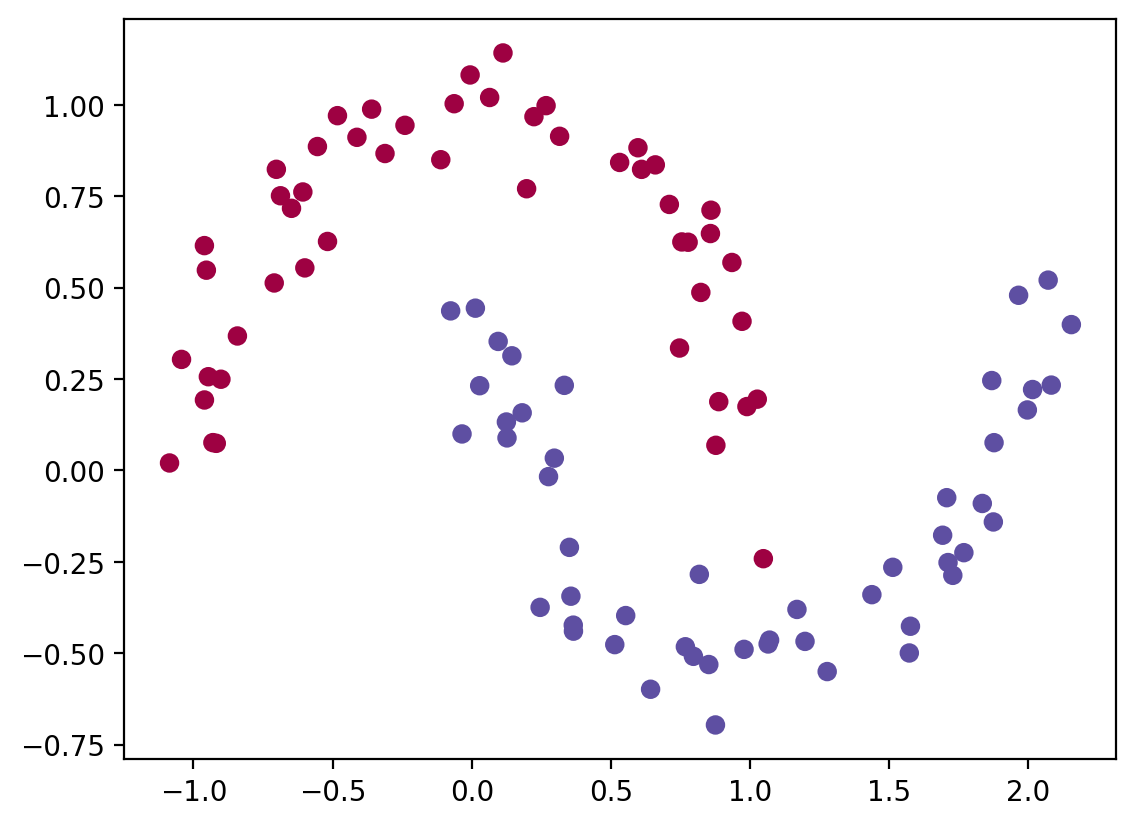

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [6]:
log_reg = LogisticRegression(2)

In [7]:
log_reg.linear.weight, log_reg.linear.bias

(Parameter containing:
 tensor([[0.2382, 0.5536]], requires_grad=True),
 Parameter containing:
 tensor([0.1851], requires_grad=True))

In [8]:
log_reg(torch.tensor([1, 0.0]))

tensor([0.4233], grad_fn=<AddBackward0>)

/Users/nipun/miniconda3/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1664817783366/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


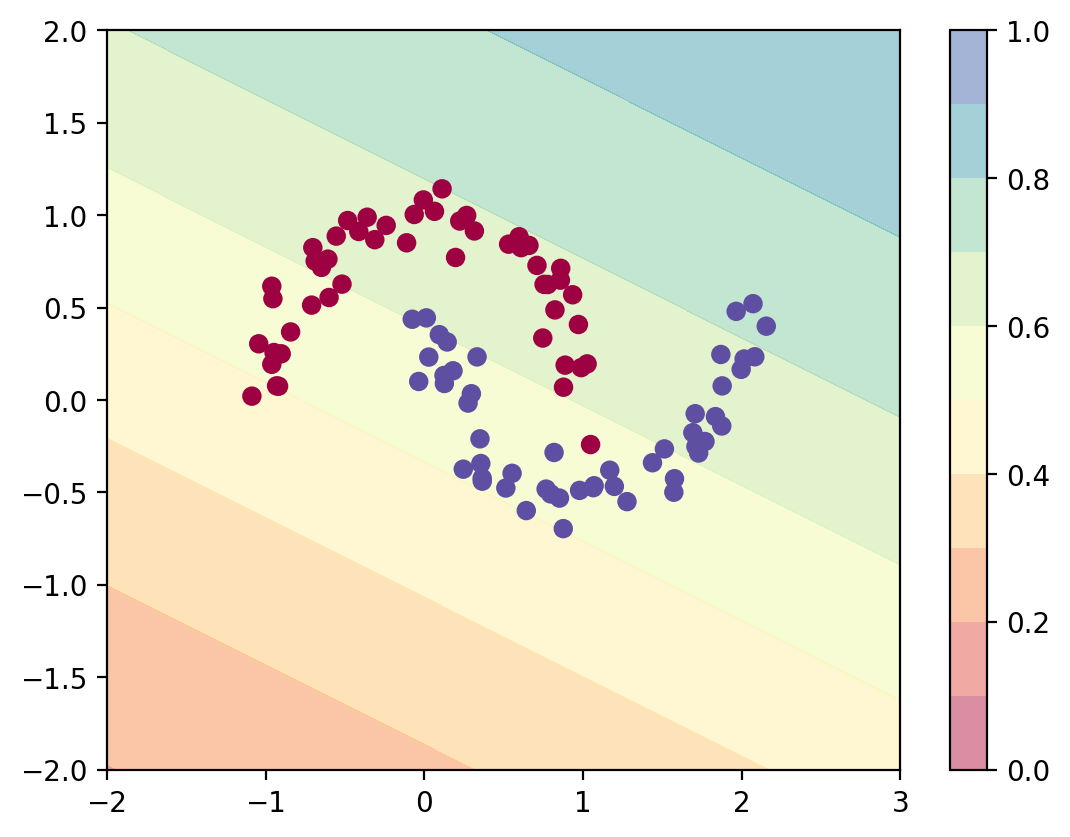

In [9]:
# Predict with the model

def predict_plot_grid(model):
    XX, YY = torch.meshgrid(torch.linspace(-2, 3, 100), torch.linspace(-2, 2, 100))
    X_grid = torch.cat([XX.unsqueeze(-1), YY.unsqueeze(-1)], dim=-1)
    logits = model(X_grid)
    probs = torch.sigmoid(logits).reshape(100, 100)
    plt.contourf(XX, YY, probs.detach().numpy(), levels=[0.0, 0.1, 0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9, 1.0], 
                 cmap=plt.cm.Spectral, alpha=0.5)
    plt.colorbar()
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    
predict_plot_grid(log_reg)
    
    

In [10]:


opt = torch.optim.Adam(log_reg.parameters(), lr=0.01)

converged = False
prev_loss = 1e8 
i = 0
while not converged:
    opt.zero_grad()
    logits = log_reg(torch.tensor(X, dtype=torch.float32))
    loss = nn.BCEWithLogitsLoss()(logits, torch.tensor(y, dtype=torch.float32).view(-1, 1))
    loss.backward()
    opt.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1


0 0.7676702737808228
10 0.7178489565849304
20 0.6734200119972229
30 0.6346784830093384
40 0.6013920903205872
50 0.5729667544364929
60 0.5486723184585571
70 0.5278077721595764
80 0.5097730755805969
90 0.4940771758556366
100 0.48032107949256897
110 0.4681788980960846
120 0.4573836922645569
130 0.44771644473075867
140 0.43899765610694885
150 0.4310801327228546
160 0.42384302616119385
170 0.4171868562698364
180 0.4110296666622162
190 0.40530359745025635
200 0.39995262026786804
210 0.3949298858642578
220 0.3901965618133545
230 0.38572028279304504
240 0.38147369027137756
250 0.37743401527404785
260 0.37358200550079346
270 0.3699013590812683
280 0.3663782775402069
290 0.3630010187625885
300 0.3597593605518341
310 0.35664474964141846
320 0.3536495566368103
330 0.35076722502708435
340 0.3479919135570526
350 0.3453184962272644
360 0.34274226427078247
370 0.3402591943740845
380 0.3378653824329376
390 0.3355572521686554
400 0.3333316147327423
410 0.33118531107902527
420 0.32911548018455505
430 0.3

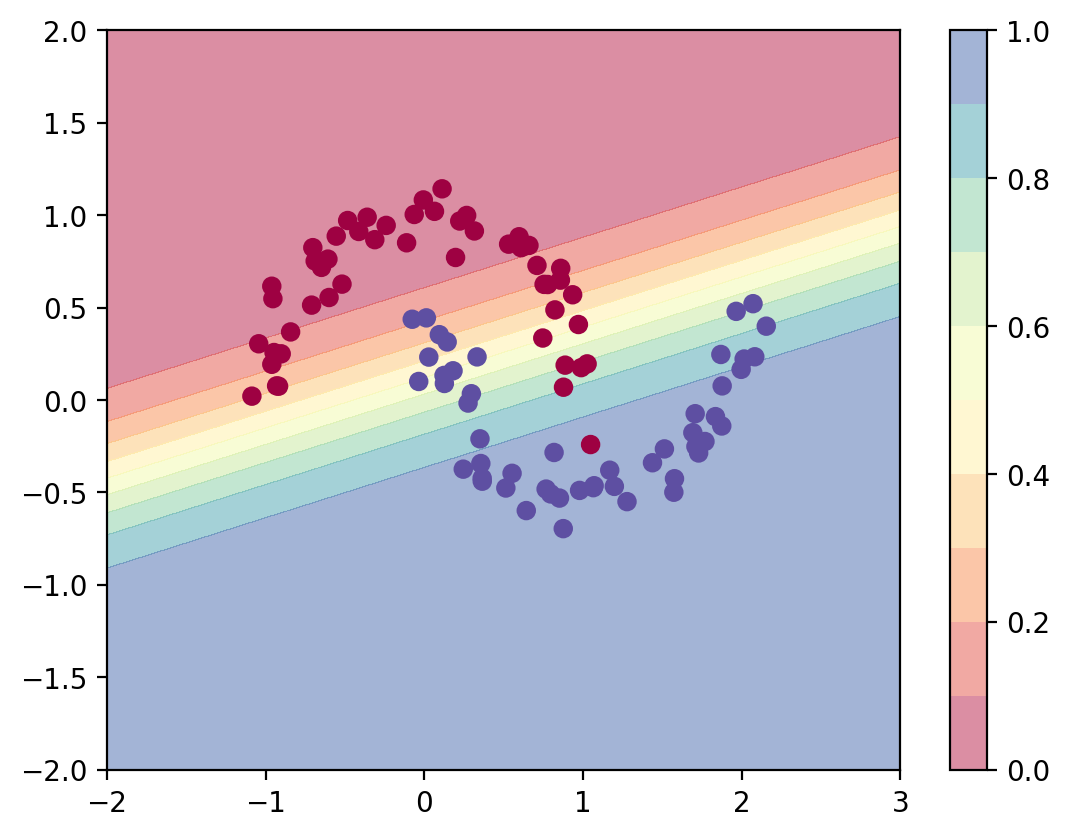

In [11]:
predict_plot_grid(log_reg)

In [12]:
# Iris dataset
from sklearn.datasets import load_iris
iris = load_iris()

In [13]:
X = iris.data
y = iris.target

Text(0, 0.5, 'Sepal width')

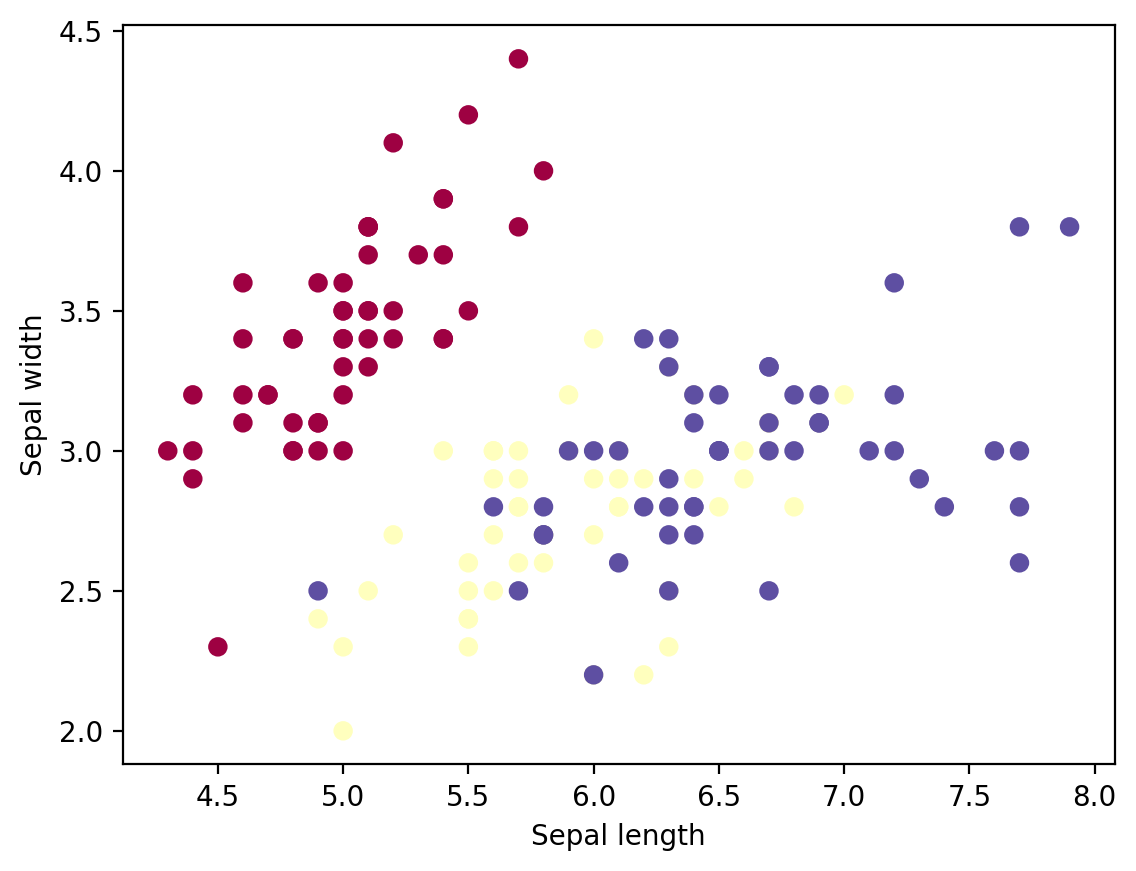

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

In [26]:
class ThreeClassLogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(ThreeClassLogisticRegression, self).__init__()
        self.linear1 = nn.Linear(input_dim, 1)
        self.linear2 = nn.Linear(input_dim, 1)
        self.linear3 = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        logits1 = self.linear1(x) #x^T theta_1 (z1)
        logits2 = self.linear2(x) # x^T theta_2 (z2)
        logits3 = self.linear3(x) # x^T theta_3 (z3)
        return torch.cat([logits1, logits2, logits3], dim=-1)
    

class MultiClassLogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MultiClassLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        logits = self.linear(x)
        return logits

In [27]:
mlr = ThreeClassLogisticRegression(2)

In [28]:
X_tensor = torch.tensor(X, dtype=torch.float32)[:,:2]
y_tensor = torch.tensor(y, dtype=torch.long)

In [29]:
X_tensor[:5]

tensor([[5.1000, 3.5000],
        [4.9000, 3.0000],
        [4.7000, 3.2000],
        [4.6000, 3.1000],
        [5.0000, 3.6000]])

In [30]:
mlr(X_tensor).shape

torch.Size([150, 3])

In [31]:
mlr(X_tensor)[:5]

tensor([[-1.0508, -5.1562,  0.7905],
        [-1.0569, -4.7130,  0.7451],
        [-1.0204, -4.7293,  0.6818],
        [-1.0143, -4.6061,  0.6553],
        [-1.0325, -5.1643,  0.7589]], grad_fn=<SliceBackward0>)

In [32]:
mlr_efficient = MultiClassLogisticRegression(2, 3)
mlr_efficient(X_tensor).shape

torch.Size([150, 3])

In [33]:
mlr_efficient(X_tensor[:5])

tensor([[ 0.5415, -3.7323, -3.4057],
        [ 0.7909, -3.5029, -3.3039],
        [ 0.5616, -3.4831, -3.1574],
        [ 0.5837, -3.4133, -3.0970],
        [ 0.4269, -3.7224, -3.3325]], grad_fn=<AddmmBackward0>)

In [34]:
z1 = 0.5415
z2 = -3.7323
z3 = -3.4057

e_z1 = np.exp(z1)
e_z2 = np.exp(z2)
e_z3 = np.exp(z3)

p1 = e_z1/(e_z1 + e_z2 + e_z3)
p2 = e_z2/(e_z1 + e_z2 + e_z3)  
p3 = e_z3/(e_z1 + e_z2 + e_z3)
print(p1, p2, p3)

0.9678317468163447 0.013480689538674706 0.018687563644980688


In [35]:
nn.Softmax(dim=-1)(mlr_efficient(X_tensor[:5]))

tensor([[0.9678, 0.0135, 0.0187],
        [0.9706, 0.0133, 0.0162],
        [0.9599, 0.0168, 0.0233],
        [0.9582, 0.0176, 0.0242],
        [0.9624, 0.0152, 0.0224]], grad_fn=<SoftmaxBackward0>)

In [22]:

nn.Softmax(dim=-1)(mlr_efficient(X_tensor[:5])).sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)

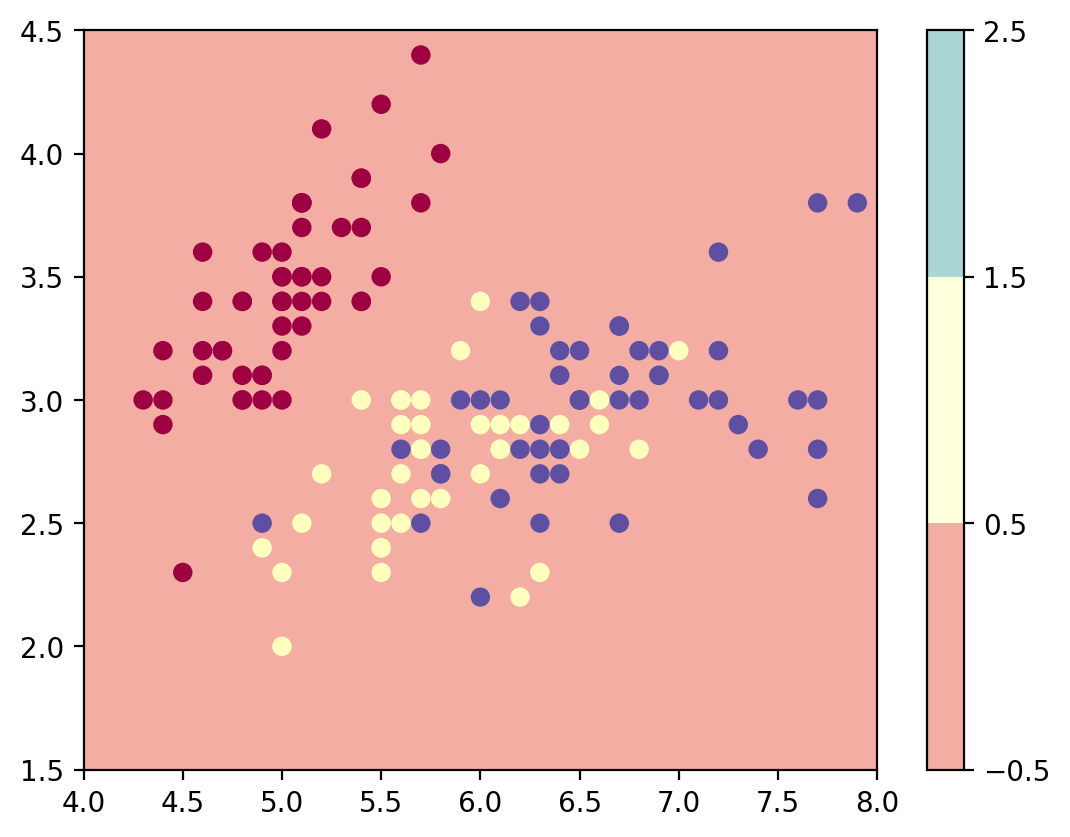

In [36]:
def plot_most_probable_class(model):
    XX, YY = torch.meshgrid(torch.linspace(4, 8, 100), torch.linspace(1.5, 4.5, 100))
    X_grid = torch.cat([XX.unsqueeze(-1), YY.unsqueeze(-1)], dim=-1)
    logits = model(X_grid)
    predicted_class = torch.argmax(logits, dim=-1)
    plt.contourf(XX, YY, predicted_class.reshape(100, 100).detach().numpy(), levels=[-0.5, 0.5, 1.5, 2.5], 
                 cmap=plt.cm.Spectral, alpha=0.5)
    plt.colorbar()

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    
plot_most_probable_class(mlr_efficient)

In [37]:
logits = mlr_efficient(X_tensor)
nn.Softmax(dim=-1)(logits[:5])

tensor([[0.9678, 0.0135, 0.0187],
        [0.9706, 0.0133, 0.0162],
        [0.9599, 0.0168, 0.0233],
        [0.9582, 0.0176, 0.0242],
        [0.9624, 0.0152, 0.0224]], grad_fn=<SoftmaxBackward0>)

In [38]:
y_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

In [39]:
opt = torch.optim.Adam(mlr_efficient.parameters(), lr=0.01)

converged = False
prev_loss = 1e8

i = 0
while not converged:
    opt.zero_grad()
    logits = mlr_efficient(X_tensor)
    loss = F.cross_entropy(logits, y_tensor)
    loss.backward()
    opt.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1

0 3.7834692001342773
10 2.5278563499450684
20 1.649053692817688
30 1.4267195463180542
40 1.4423983097076416
50 1.4182347059249878
60 1.3853305578231812
70 1.3675893545150757
80 1.34984290599823
90 1.3303377628326416
100 1.3111019134521484
110 1.2913520336151123
120 1.2712701559066772
130 1.2509937286376953
140 1.2305757999420166
150 1.2101225852966309
160 1.1897128820419312
170 1.169424295425415
180 1.149324655532837
190 1.129475712776184
200 1.1099324226379395
210 1.090742826461792
220 1.071947693824768
230 1.0535815954208374
240 1.0356725454330444
250 1.0182429552078247
260 1.0013093948364258
270 0.9848831295967102
280 0.9689714312553406
290 0.9535769820213318
300 0.938698410987854
310 0.9243322610855103
320 0.9104706645011902
330 0.8971052169799805
340 0.884224534034729
350 0.8718162178993225
360 0.8598660230636597
370 0.8483598232269287
380 0.8372823596000671
390 0.8266181349754333
400 0.8163511157035828
410 0.8064659833908081
420 0.7969467639923096
430 0.7877782583236694
440 0.778

In [40]:
mlr_efficient(X_tensor[:5])

tensor([[ 1.5142, -3.6661, -5.1945],
        [ 0.2573, -1.6901, -3.7988],
        [ 1.6097, -3.0577, -5.3911],
        [ 1.5404, -2.7862, -5.3336],
        [ 2.1904, -4.3499, -5.9906]], grad_fn=<AddmmBackward0>)

In [41]:
pred = F.softmax(mlr_efficient(X_tensor), dim=-1).detach().numpy()
pd.DataFrame(pred)

,0,1,2
0,0.993200,0.005588,0.001212
1,0.862100,0.122973,0.014927
2,0.989798,0.009300,0.000902
3,0.985954,0.013027,0.001020
4,0.998279,0.001442,0.000279
...,...,...,...
145,0.000221,0.303988,0.695791
146,0.000041,0.519632,0.480326
147,0.000760,0.376843,0.622397
148,0.110826,0.396854,0.492319


In [42]:
import pandas as pd

In [43]:
df = pd.DataFrame(pred, columns=iris.target_names)
df["GT"] = iris.target
df

,setosa,versicolor,virginica,GT
0,0.993200,0.005588,0.001212,0
1,0.862100,0.122973,0.014927,0
2,0.989798,0.009300,0.000902,0
3,0.985954,0.013027,0.001020,0
4,0.998279,0.001442,0.000279,0
...,...,...,...,...
145,0.000221,0.303988,0.695791,2
146,0.000041,0.519632,0.480326,2
147,0.000760,0.376843,0.622397,2
148,0.110826,0.396854,0.492319,2


In [44]:
# Find prediction
y_pred = pred.argmax(axis=-1)

df["Predicted Class"] = y_pred


In [45]:
df

,setosa,versicolor,virginica,GT,Predicted Class
0,0.993200,0.005588,0.001212,0,0
1,0.862100,0.122973,0.014927,0,0
2,0.989798,0.009300,0.000902,0,0
3,0.985954,0.013027,0.001020,0,0
4,0.998279,0.001442,0.000279,0,0
...,...,...,...,...,...
145,0.000221,0.303988,0.695791,2,2
146,0.000041,0.519632,0.480326,2,1
147,0.000760,0.376843,0.622397,2,2
148,0.110826,0.396854,0.492319,2,2


In [46]:
# Accuracy
(y_pred == iris.target).mean()

0.8266666666666667

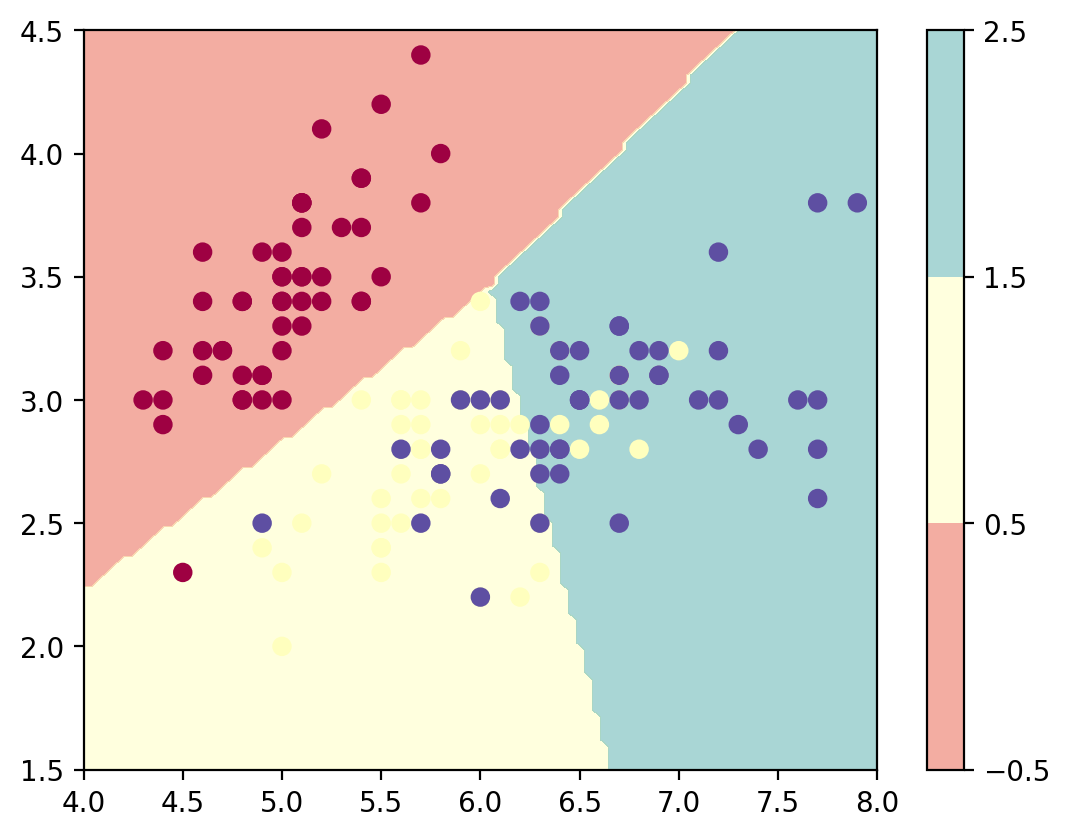

In [47]:
plot_most_probable_class(mlr_efficient)

In [48]:
# Add more features like x^2, xy, y^2

X = iris.data
y = iris.target

X = np.concatenate([X, X**2, X[:, [0]]*X[:, [1]], X[:, [1]]**2], axis=-1)

X_tensor = torch.tensor(X, dtype=torch.float32)

mlr_efficient = MultiClassLogisticRegression(10, 3)


opt = torch.optim.Adam(mlr_efficient.parameters(), lr=0.01)

converged = False

prev_loss = 1e8

i = 0
while not converged:
    opt.zero_grad()
    logits = mlr_efficient(X_tensor)
    loss = F.cross_entropy(logits, y_tensor)
    loss.backward()
    opt.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1
    


0 7.328600883483887
10 2.1260838508605957
20 1.142831563949585
30 0.860477089881897
40 0.6673010587692261
50 0.48362672328948975
60 0.40385228395462036
70 0.33903008699417114
80 0.2988366484642029
90 0.26774561405181885
100 0.24411135911941528
110 0.2247859686613083
120 0.2087727040052414
130 0.19520965218544006
140 0.18358972668647766
150 0.17353105545043945
160 0.16474705934524536
170 0.15701723098754883
180 0.150166854262352
190 0.14405710995197296
200 0.138575941324234
210 0.13363228738307953
220 0.12915153801441193
230 0.12507188320159912
240 0.12134184688329697
250 0.11791844666004181
260 0.11476516723632812
270 0.11185110360383987
280 0.10914991796016693
290 0.10663879662752151
300 0.1042981818318367
310 0.1021110936999321
320 0.10006263852119446
330 0.09813988208770752
340 0.096331387758255
350 0.09462711215019226
360 0.09301812201738358
370 0.09149643033742905
380 0.09005502611398697
390 0.08868753910064697
400 0.08738835155963898
410 0.08615230768918991
420 0.0849747881293296

In [49]:
# Accuracy
pred = F.softmax(mlr_efficient(X_tensor), dim=-1).detach().numpy()
y_pred = pred.argmax(axis=-1)
(y_pred == iris.target).mean()

0.9866666666666667